In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import load_model,Model
import random
import math
import threading
import time

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
import copy
x_tmp = copy.deepcopy(x_test[0])

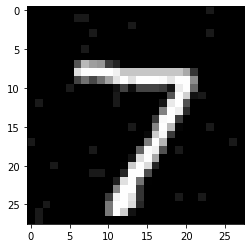

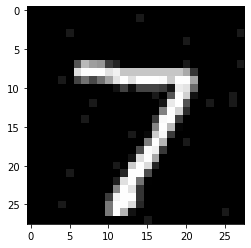

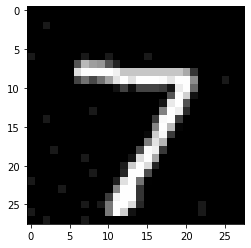

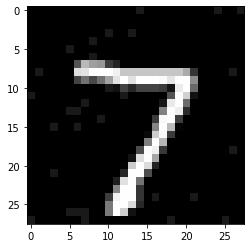

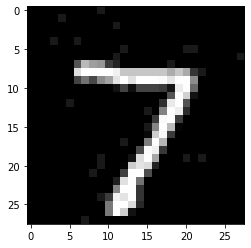

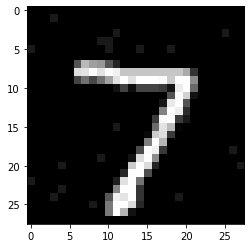

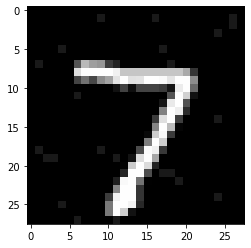

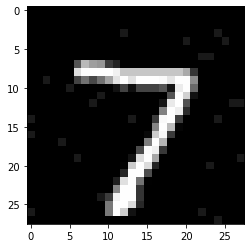

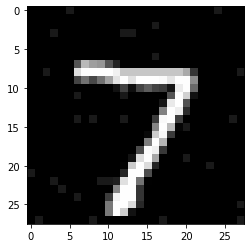

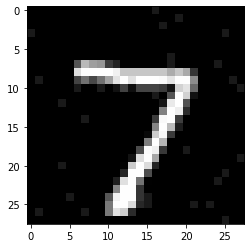

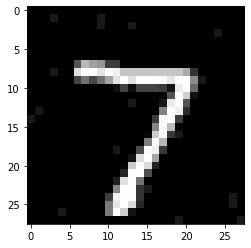

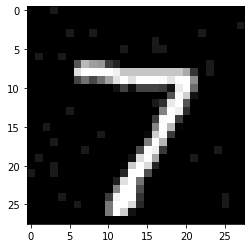

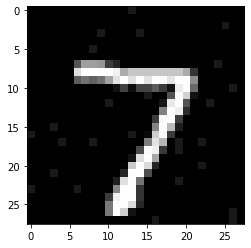

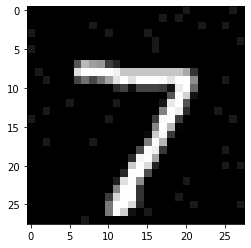

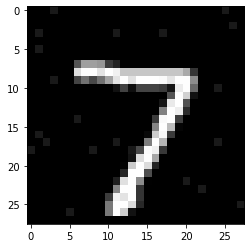

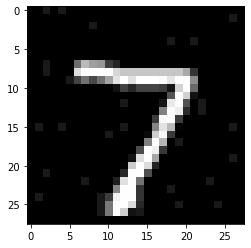

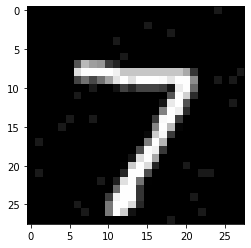

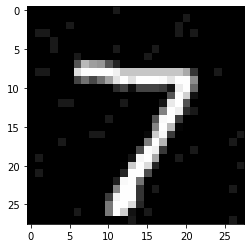

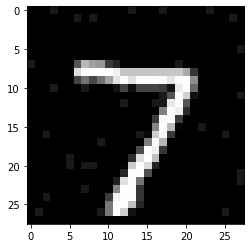

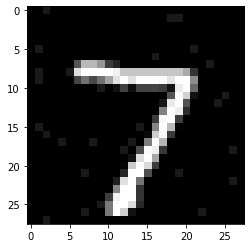

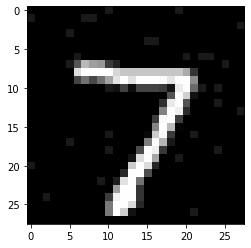

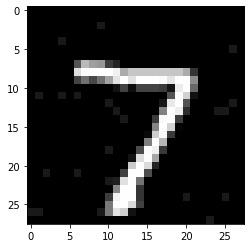

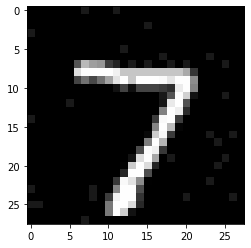

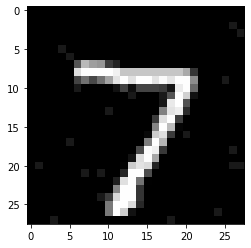

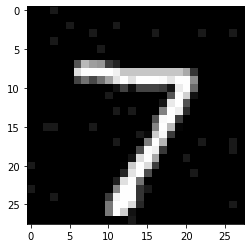

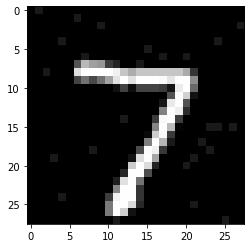

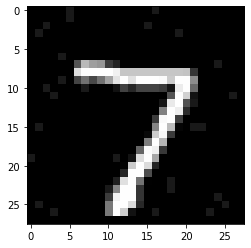

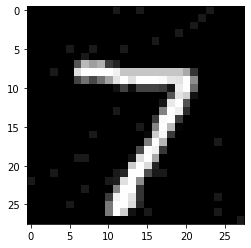

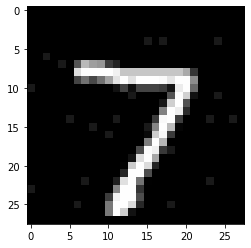

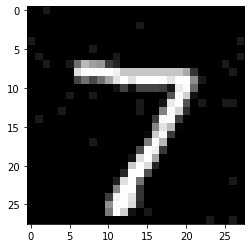

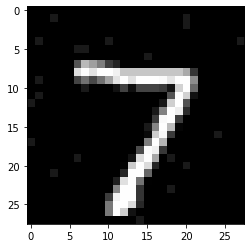

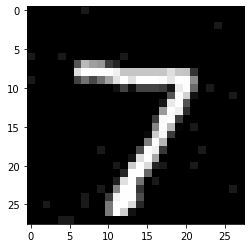

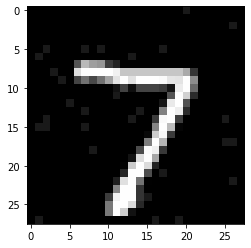

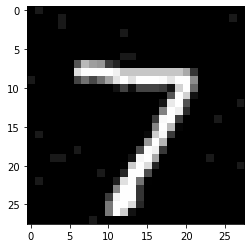

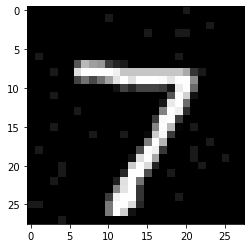

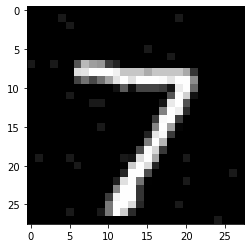

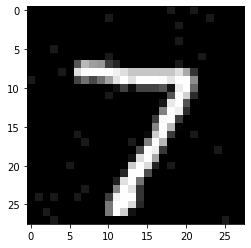

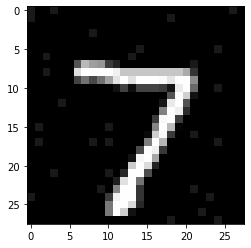

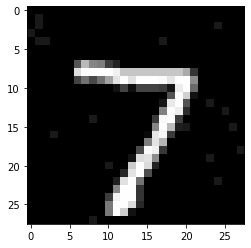

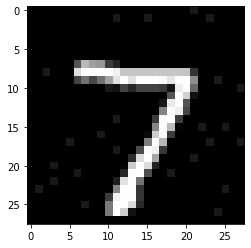

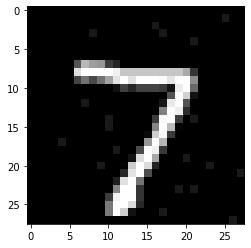

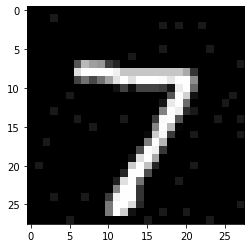

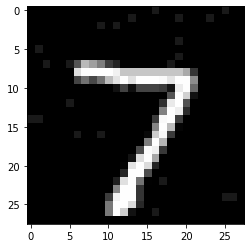

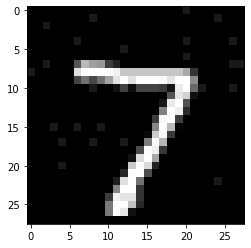

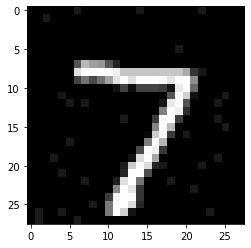

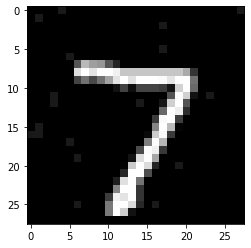

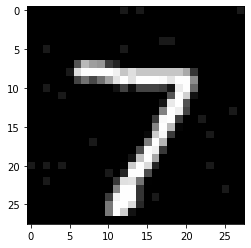

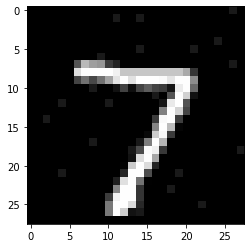

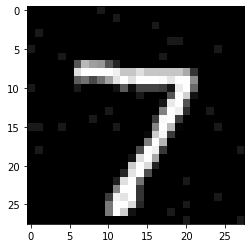

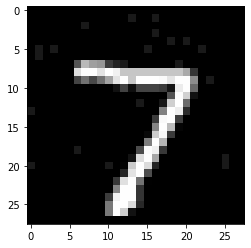

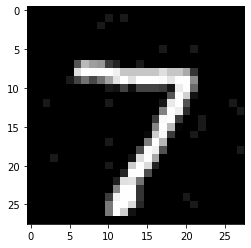

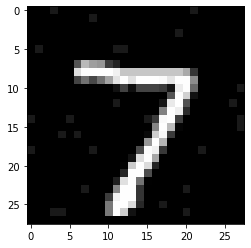

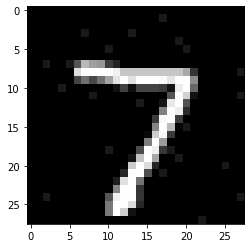

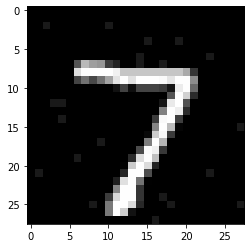

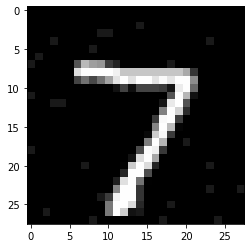

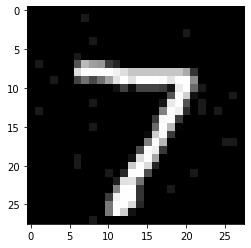

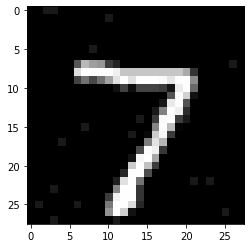

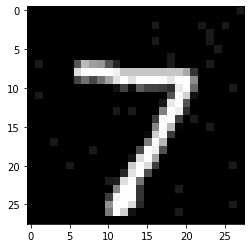

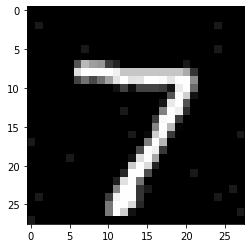

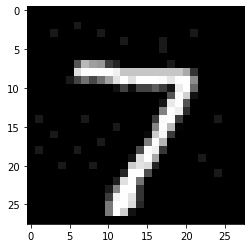

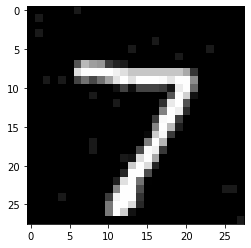

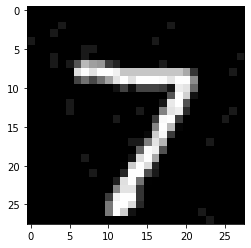

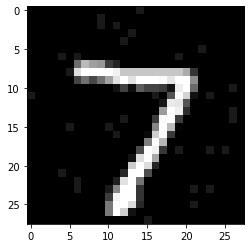

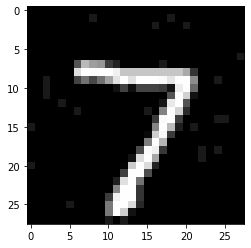

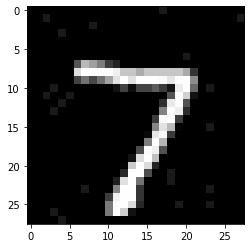

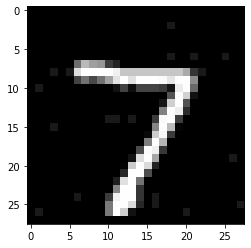

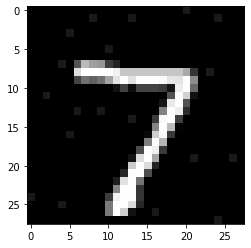

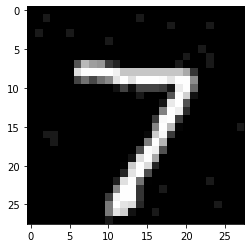

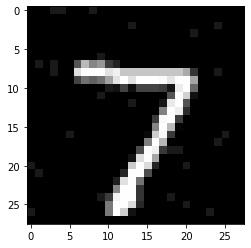

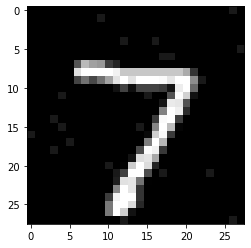

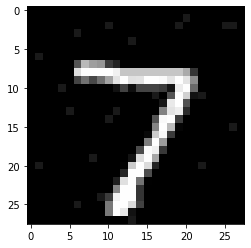

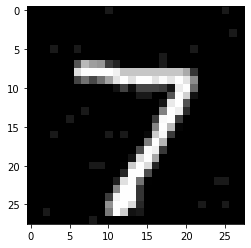

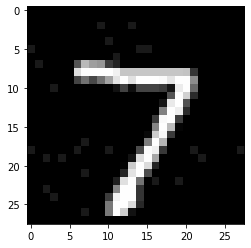

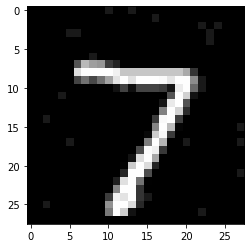

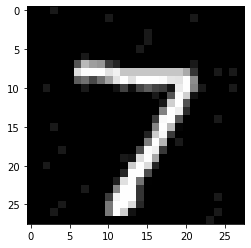

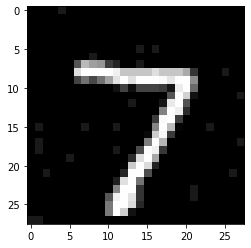

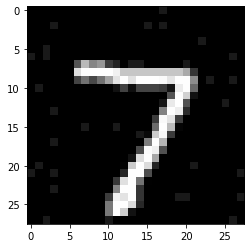

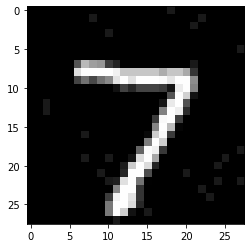

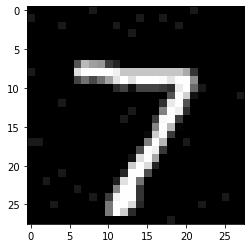

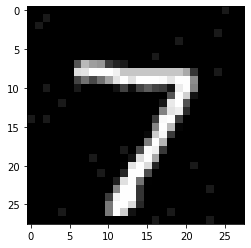

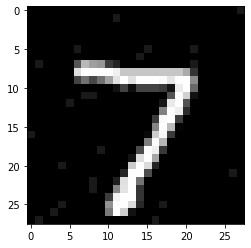

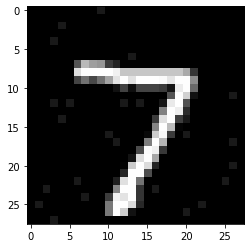

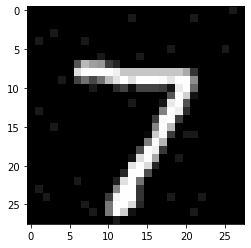

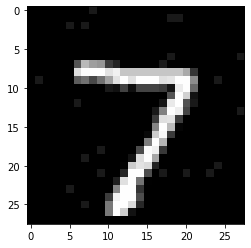

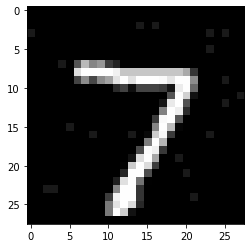

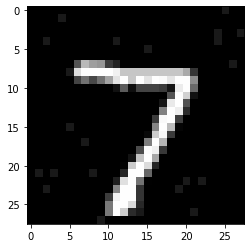

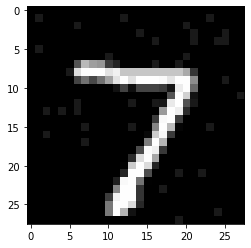

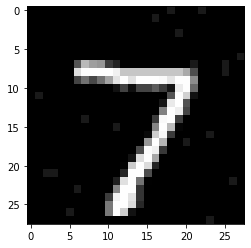

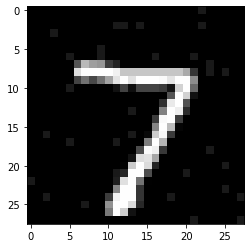

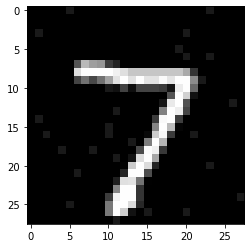

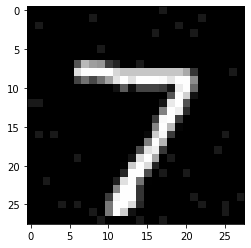

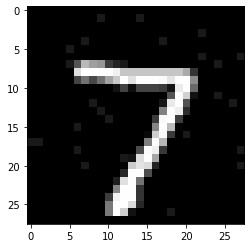

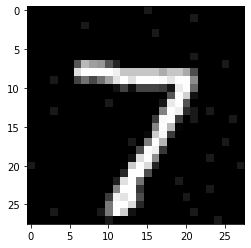

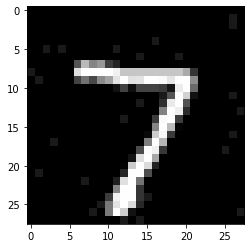

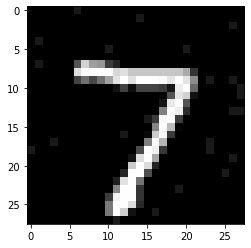

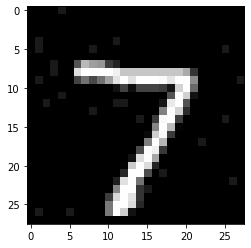

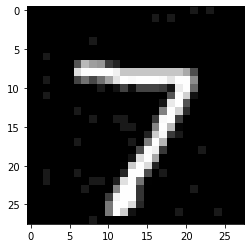

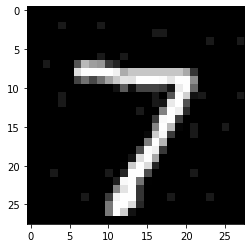

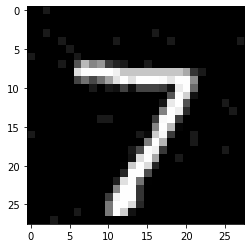

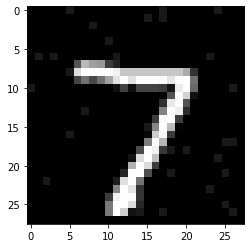

In [4]:
#产生扰动种群
x_des = []
for r in range(100):
    for i in range(28):
        for j in range(28):
            x= random.randint(0,10000)/10000
            if x <= 0.1:
                u = x_tmp[i,j] # 期望值μ
                sig = math.sqrt(0.2) # 标准差δ
                x_ = random.uniform(u - 3*sig, u + 3*sig)
                y_sig = np.exp(-(x_ - u) ** 2 /(2* sig **2))/(math.sqrt(2*math.pi)*sig)
                y_= random.randint(0,10000)/10000
                if y_ <= y_sig:
                    if x_test[0][i,j] <= 127:
                        x_tmp[i,j] += 255*0.1
                    elif x_test[0][i,j] > 127 and x_test[0][i,j] < 229:
                        y = random.randint(0,10000)/10000
                        if y <= 0.5:
                            x_tmp[i,j] += 255*0.1
                        else:
                            x_tmp[i,j] -= 255*0.1
                    elif x_test[0][i,j] >= 229:
                        x_tmp[i,j] -= 255*0.1
    x_t = x_tmp/255-x_test[0]/255
    #x_des.append(np.array (x_t.reshape(1,784)))
    x_des.append(np.array(x_t.reshape(1,784)))
    plt.imshow(x_tmp,cmap='gray')
    plt.show()
    x_tmp = copy.deepcopy(x_test[0])

In [6]:
x_train = x_train.reshape(60000,784)    # 将图片摊平，变成向量

In [7]:
x_test = x_test.reshape(10000,784)     # 对测试集进行同样的处理

In [8]:
x_train = x_train / 255
x_test = x_test / 255 

In [9]:
model = load_model('mnist_model.h5')

In [10]:
def Func(x):
    x_F = x[:]+x_test[0]
    result=model.predict(x_F.reshape(1,784))
    return result[0][7]

In [11]:
def Dis(x):   # 扰动值
    res = 0
    for i in range(784):
        l = x[i]
        res += l**2
    return res

In [11]:
# 攻击模块
class Atk(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Atk, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        self.cond.acquire()
        print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            DB = Dis(BEST_X)    # 存储上一代的扰动程度
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                
                D_ = DIS_U[i] - DB
                # 变异的种子表现更好
                if FITS[i] >= FITS_U[i] and D_ < 0.1:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if FITS_U[i] < Func(BEST_X) and D_ < 0.1:
                        BEST_X = U[i, :]
            GENERATION += 1
            
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            if Func(best) > 0.5:
                best[:] = BEST_X[:]
            if Func(BEST_X) < 0.5 and Dis(BEST_X) < 6.0:
                if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):   # 保存最好的数值
                    best[:] = BEST_X[:]
                    print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            
            if Func(BEST_X) <= F:
                print("resume")
                if D < 6.5:
                    D += 0.4 
                self.cond.notify()  # 唤醒一个挂起的线程
                self.cond.wait()
        self.cond.release()


# 恢复模块
class Re(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Re, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        #time.sleep(1)
        self.cond.acquire()
        self.cond.wait()
        #print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            FB = Func(BEST_X)    # 存储上一代的置信度
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i]) 
                F_ = FITS_U[i] - FB
                
                # 变异的种子表现更好
                #if FITS[i] >= FITS_U[i] and DIS[i] >= DIS_U[i]:
                if DIS[i] >= DIS_U[i] and F_ < 0.01:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if DIS_U[i] < Dis(BEST_X) and F_ < 0.01:
                        BEST_X = U[i, :]
            GENERATION += 1
            #print(F_)
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            if Func(best) > 0.5:
                best[:] = BEST_X[:]
            if Func(BEST_X) < 0.5 and Dis(BEST_X) < 6.0:
                if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):   # 保存最好的数值
                    best[:] = BEST_X[:]
                    print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            
            if Dis(BEST_X) <= D:
                print("attack")
                if F > 0.3:
                    F -= 0.1
                self.cond.notify()
                self.cond.wait()
        self.cond.release()
        

In [12]:
MAX_GENERATION = 1000  # 最大迭代次数
GENERATION = 0  # 当前代数
L = 784  # 种子的维度
N = 100  # 种群规模
SIGMA = 0.333  # 缩放因子
CR = 0.1  # 交叉概率
F = 0.8   #置信度参数
D = 3.0   #扰动参数
cond = threading.Condition()
atk = Atk(cond, "attack")
re = Re(cond, "resume")
best = 0
GENERATION = 0  # 当前代数
BEST_X = 0
FITS = np.zeros(N)
FITS_U = np.zeros(N)
DIS = np.zeros(N)
DIS_U = np.zeros(N)
V = np.zeros((N, L))
U = np.zeros((N, L))
# 1、初始化
X = np.concatenate(x_des, axis=0)
# 找出随机生成的最好的种子
for i in range(N):
    FITS[i] = Func(X[i])
# 找出最好的种子 适应度值最小
BEST_X = X[np.argmin(FITS)]
best = X[np.argmin(FITS)]
re.start()
atk.start()

#re.join()
#atk.join()
if Func(BEST_X) < 0.4:
    BEST_F = BEST_X+x_test[0]
    #print(BEST_X_F)
    plt.imshow(BEST_F.reshape(28,28),cmap='gray')
    plt.show()
    #break

attack
最优值： 0.99675995 扰动程度： 0.2736118608227606 代数： 1
最优值： 0.9966838 扰动程度： 0.27768136259114196 代数： 2
最优值： 0.99658406 扰动程度： 0.3240798607527972 代数： 3
最优值： 0.99652123 扰动程度： 0.3722505358913804 代数： 4
最优值： 0.9964588 扰动程度： 0.2756569496055653 代数： 5
最优值： 0.9963229 扰动程度： 0.3136882769495208 代数： 6
最优值： 0.99613625 扰动程度： 0.3813655181988042 代数： 7
最优值： 0.99606436 扰动程度： 0.31459332653417554 代数： 8
最优值： 0.99592316 扰动程度： 0.36021815924800327 代数： 9
最优值： 0.9958473 扰动程度： 0.388211518412683 代数： 10
最优值： 0.9956527 扰动程度： 0.4093800338075522 代数： 11
最优值： 0.99554896 扰动程度： 0.42615579665647707 代数： 12
最优值： 0.99545187 扰动程度： 0.4482660117286404 代数： 13
最优值： 0.9953164 扰动程度： 0.4645927944992703 代数： 14
最优值： 0.9951444 扰动程度： 0.47505514921473546 代数： 15
最优值： 0.99494946 扰动程度： 0.5355943602062023 代数： 16
最优值： 0.994743 扰动程度： 0.5825047857395202 代数： 17
最优值： 0.9947241 扰动程度： 0.5803301302987716 代数： 18
最优值： 0.9946227 扰动程度： 0.5558348451721172 代数： 19
最优值： 0.9943851 扰动程度： 0.6165867627755285 代数： 20
最优值： 0.9942391 扰动程度： 0.5868695019758237 代数： 21
最优值

最优值： 0.8179496 扰动程度： 4.670550596294503 代数： 174
最优值： 0.80893785 扰动程度： 4.707031662389844 代数： 175
最优值： 0.8075039 扰动程度： 4.699962947186305 代数： 176
最优值： 0.8074491 扰动程度： 4.706215026264233 代数： 177
最优值： 0.8072273 扰动程度： 4.709684318323267 代数： 178
最优值： 0.800874 扰动程度： 4.788390121266431 代数： 179
最优值： 0.80292094 扰动程度： 4.756290906038451 代数： 180
最优值： 0.7991895 扰动程度： 4.83797954627382 代数： 181
resume
最优值： 0.8091846 扰动程度： 4.673125907065723 代数： 182
最优值： 0.8159605 扰动程度： 4.507187790182198 代数： 183
最优值： 0.8206341 扰动程度： 4.4515580930983845 代数： 184
最优值： 0.8212898 扰动程度： 4.428633844848121 代数： 185
最优值： 0.8245188 扰动程度： 4.37091398287651 代数： 186
最优值： 0.8297291 扰动程度： 4.259671431716963 代数： 187
最优值： 0.82998174 扰动程度： 4.254031215545104 代数： 188
最优值： 0.8373312 扰动程度： 4.18294224606352 代数： 189
最优值： 0.8403312 扰动程度： 4.1761553694610285 代数： 190
最优值： 0.8447032 扰动程度： 4.061767837174099 代数： 191
最优值： 0.8469916 扰动程度： 3.929325587651958 代数： 192
最优值： 0.8446122 扰动程度： 3.8894927724157533 代数： 193
最优值： 0.851967 扰动程度： 3.7919364677626013 代数： 194
最优值：

最优值： 0.66576725 扰动程度： 5.490232276535249 代数： 346
最优值： 0.65886754 扰动程度： 5.584673146981555 代数： 347
最优值： 0.65312773 扰动程度： 5.5999528548319475 代数： 348
最优值： 0.6494283 扰动程度： 5.68828307211767 代数： 349
最优值： 0.64718884 扰动程度： 5.7070246759505725 代数： 350
最优值： 0.63548905 扰动程度： 5.77695700857402 代数： 351
最优值： 0.6276026 扰动程度： 5.829428518612391 代数： 352
最优值： 0.62665707 扰动程度： 5.862200617641957 代数： 353
最优值： 0.62551546 扰动程度： 5.799321021540628 代数： 354
最优值： 0.6243128 扰动程度： 5.853649218183082 代数： 355
最优值： 0.62150574 扰动程度： 5.877943300682992 代数： 356
最优值： 0.60741454 扰动程度： 5.929371382709194 代数： 357
最优值： 0.6084718 扰动程度： 5.930516470224624 代数： 358
最优值： 0.6031501 扰动程度： 5.949795537531271 代数： 359
最优值： 0.6020364 扰动程度： 5.95352808748083 代数： 360
最优值： 0.60198045 扰动程度： 5.957529460634514 代数： 361
最优值： 0.6027404 扰动程度： 5.957178280854462 代数： 362
最优值： 0.5957552 扰动程度： 6.033139434788443 代数： 363
resume
最优值： 0.60304797 扰动程度： 5.936703764896335 代数： 364
最优值： 0.6103975 扰动程度： 5.878595965032673 代数： 365
最优值： 0.61131406 扰动程度： 5.829850964550578 代数：

最优值： 0.5263087 扰动程度： 6.074689878876635 代数： 519
最优值： 0.52607125 扰动程度： 6.074530936313493 代数： 520
最优值： 0.5247916 扰动程度： 6.077114039039616 代数： 521
最优值： 0.52420366 扰动程度： 6.145806146468904 代数： 522
最优值： 0.51636255 扰动程度： 6.224722288346401 代数： 523
最优值： 0.517354 扰动程度： 6.292599959955791 代数： 524
最优值： 0.5088819 扰动程度： 6.242461180692808 代数： 525
最优值： 0.50485253 扰动程度： 6.269946542470668 代数： 526
最优值： 0.50268954 扰动程度： 6.295859136829319 代数： 527
最优值： 0.5009958 扰动程度： 6.320507011563155 代数： 528
最优值： 0.50117 扰动程度： 6.334413739319359 代数： 529
最优值： 0.49484813 扰动程度： 6.373594177781271 代数： 530
最优值： 0.49208727 扰动程度： 6.454131380876644 代数： 531
最优值： 0.47859144 扰动程度： 6.522251776014181 代数： 532
最优值： 0.47280455 扰动程度： 6.603277691751697 代数： 533
最优值： 0.46681648 扰动程度： 6.6805010312810555 代数： 534
最优值： 0.45509818 扰动程度： 6.7649982539190505 代数： 535
最优值： 0.44943807 扰动程度： 6.7831437564681245 代数： 536
最优值： 0.44946587 扰动程度： 6.763783334283321 代数： 537
最优值： 0.44870567 扰动程度： 6.796014883074926 代数： 538
最优值： 0.44513583 扰动程度： 6.837899834484811 代数： 53

最优值： 0.3644534 扰动程度： 7.1821786728919665 代数： 691
最优值： 0.36530662 扰动程度： 7.174763263525472 代数： 692
最优值： 0.36746177 扰动程度： 7.14545330377892 代数： 693
最优值： 0.36883336 扰动程度： 7.090853938748958 代数： 694
最优值： 0.3756723 扰动程度： 6.995492649037158 代数： 695
最优值： 0.3852758 扰动程度： 6.896616751902307 代数： 696
最优值： 0.3840296 扰动程度： 6.910414297139397 代数： 697
最优值： 0.38742357 扰动程度： 6.91414565478922 代数： 698
最优值： 0.3966102 扰动程度： 6.819696341469875 代数： 699
最优值： 0.40116668 扰动程度： 6.804362664969933 代数： 700
最优值： 0.40188435 扰动程度： 6.786693848698321 代数： 701
最优值： 0.4031198 扰动程度： 6.766388862460985 代数： 702
最优值： 0.40866023 扰动程度： 6.742753964863648 代数： 703
最优值： 0.41510788 扰动程度： 6.691113267568742 代数： 704
最优值： 0.40438858 扰动程度： 6.672313328918399 代数： 705
最优值： 0.4131986 扰动程度： 6.668112756241006 代数： 706
最优值： 0.42095497 扰动程度： 6.622389395664066 代数： 707
最优值： 0.4302357 扰动程度： 6.492982224945516 代数： 708
最优值： 0.43085164 扰动程度： 6.472542777729469 代数： 709
最优值： 0.432694 扰动程度： 6.458107231892144 代数： 710
最优值： 0.43209034 扰动程度： 6.4243369208342145 代数： 711
最优

最优值： 0.22994274 扰动程度： 8.556864655211863 代数： 863
最优值： 0.23099497 扰动程度： 8.471374033235163 代数： 864
最优值： 0.23933147 扰动程度： 8.330115088227958 代数： 865
最优值： 0.24055776 扰动程度： 8.27575690588092 代数： 866
最优值： 0.24703632 扰动程度： 8.226967004158807 代数： 867
最优值： 0.2522357 扰动程度： 8.208651052104678 代数： 868
最优值： 0.24839908 扰动程度： 8.168840584643144 代数： 869
最优值： 0.25546885 扰动程度： 8.093004623273671 代数： 870
最优值： 0.261627 扰动程度： 8.023236986405042 代数： 871
最优值： 0.26820388 扰动程度： 7.960052008670978 代数： 872
最优值： 0.2745345 扰动程度： 7.832449527087773 代数： 873
最优值： 0.28130296 扰动程度： 7.773665228769824 代数： 874
最优值： 0.2835401 扰动程度： 7.784651391722398 代数： 875
最优值： 0.29254135 扰动程度： 7.65208767054357 代数： 876
最优值： 0.29364294 扰动程度： 7.6221448359044865 代数： 877
最优值： 0.2944374 扰动程度： 7.604671240225275 代数： 878
最优值： 0.29358503 扰动程度： 7.606668641261131 代数： 879
最优值： 0.29760182 扰动程度： 7.596260558223293 代数： 880
最优值： 0.3052042 扰动程度： 7.548009903483025 代数： 881
最优值： 0.31873968 扰动程度： 7.5045404975432515 代数： 882
最优值： 0.31257325 扰动程度： 7.440745409650761 代数： 883

In [13]:
best

array([ 0.00000000e+00,  5.35446947e-06,  1.10066385e-04,  2.65087651e-02,
        4.63640851e-03,  8.33594749e-03,  1.30169376e-01,  0.00000000e+00,
        0.00000000e+00,  1.86479028e-01,  4.71923855e-03,  2.45130966e-07,
        0.00000000e+00,  1.29319669e-03,  3.23656286e-04,  0.00000000e+00,
        0.00000000e+00,  5.64201835e-02,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  5.69889149e-04,  1.51863814e-01,  1.22502850e-03,
        9.67149149e-08,  1.40191334e-02,  1.07860499e-02,  6.14505016e-03,
        0.00000000e+00,  0.00000000e+00,  2.13457171e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.37693103e-03,  4.48800554e-03,
        2.18240656e-03,  3.93665228e-01,  6.59929245e-06,  0.00000000e+00,
        1.62396368e-01,  6.26923415e-07,  4.55552430e-03,  0.00000000e+00,
        1.15290860e-04,  3.94743427e-04,  0.00000000e+00,  0.00000000e+00,
        7.59018538e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.99660678e-05,  

In [14]:
print("最优值：", Func(best),"扰动程度：",Dis(best))

最优值： 0.49906772 扰动程度： 6.045959912371567


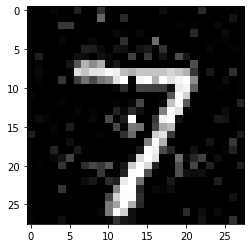

In [15]:
BEST = best + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [16]:
BEST_X

array([ 0.00000000e+00,  5.35446947e-06,  1.10066385e-04,  2.65087651e-02,
        4.63640851e-03,  8.33594749e-03,  1.30169376e-01,  0.00000000e+00,
        0.00000000e+00,  1.86479028e-01,  4.71923855e-03,  2.45130966e-07,
        0.00000000e+00,  1.29319669e-03,  3.23656286e-04,  0.00000000e+00,
        0.00000000e+00,  5.64201835e-02,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  5.69889149e-04,  1.51863814e-01,  1.22502850e-03,
        9.67149149e-08,  1.40191334e-02,  1.07860499e-02,  6.14505016e-03,
        0.00000000e+00,  0.00000000e+00,  2.13457171e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.37693103e-03,  4.48800554e-03,
        2.18240656e-03,  3.93665228e-01,  6.59929245e-06,  0.00000000e+00,
        1.62396368e-01,  6.26923415e-07,  4.55552430e-03,  0.00000000e+00,
        1.15290860e-04,  3.94743427e-04,  0.00000000e+00,  0.00000000e+00,
        7.59018538e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.99660678e-05,  

In [13]:
best=np.array([ 0.00000000e+00,  5.35446947e-06,  1.10066385e-04,  2.65087651e-02,
        4.63640851e-03,  8.33594749e-03,  1.30169376e-01,  0.00000000e+00,
        0.00000000e+00,  1.86479028e-01,  4.71923855e-03,  2.45130966e-07,
        0.00000000e+00,  1.29319669e-03,  3.23656286e-04,  0.00000000e+00,
        0.00000000e+00,  5.64201835e-02,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  5.69889149e-04,  1.51863814e-01,  1.22502850e-03,
        9.67149149e-08,  1.40191334e-02,  1.07860499e-02,  6.14505016e-03,
        0.00000000e+00,  0.00000000e+00,  2.13457171e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.37693103e-03,  4.48800554e-03,
        2.18240656e-03,  3.93665228e-01,  6.59929245e-06,  0.00000000e+00,
        1.62396368e-01,  6.26923415e-07,  4.55552430e-03,  0.00000000e+00,
        1.15290860e-04,  3.94743427e-04,  0.00000000e+00,  0.00000000e+00,
        7.59018538e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.99660678e-05,  0.00000000e+00,  7.13965785e-02,  3.53766368e-05,
        0.00000000e+00,  1.33003472e-04,  0.00000000e+00,  0.00000000e+00,
        2.16577752e-01,  2.18842667e-01,  1.63063581e-03,  0.00000000e+00,
        0.00000000e+00,  1.15540686e-02,  3.57995331e-04,  6.85388303e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  7.53033137e-04,
        1.62446424e-03,  5.17633217e-04,  0.00000000e+00,  1.46937797e-02,
        9.27417927e-03,  1.77447910e-02,  0.00000000e+00,  5.19971255e-05,
        3.62442488e-02,  0.00000000e+00,  4.93345921e-07,  0.00000000e+00,
        7.92003290e-03,  4.96112902e-03,  9.06820772e-04,  3.62787287e-07,
        3.51221876e-05,  9.91824265e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.53551570e-04,  1.68619328e-03,  3.13939327e-02,
        1.43932266e-02,  1.30434814e-04,  2.41866090e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.39059996e-04,  1.28273110e-05,
        0.00000000e+00,  1.53006846e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.95367972e-02,  5.81624529e-05,  0.00000000e+00,
        0.00000000e+00,  8.14253466e-04,  0.00000000e+00,  2.34944768e-04,
        2.76377211e-02,  0.00000000e+00,  3.79390784e-04,  0.00000000e+00,
        3.37060646e-02,  0.00000000e+00,  2.83910340e-06,  0.00000000e+00,
        1.80264687e-01,  0.00000000e+00,  0.00000000e+00,  1.26662846e-02,
        4.21576033e-01,  7.45457287e-04,  1.07576400e-03,  2.23198202e-04,
        0.00000000e+00,  1.39764550e-05,  0.00000000e+00,  4.61169471e-03,
        9.42383722e-03,  1.78260586e-02,  0.00000000e+00,  4.60859433e-06,
       -0.00000000e+00,  5.63072953e-04,  0.00000000e+00,  3.99381279e-04,
        9.61133164e-04,  0.00000000e+00,  0.00000000e+00,  1.21082346e-01,
        1.12047577e-01,  3.55763358e-02,  4.43323203e-04,  7.26039761e-02,
        5.52356674e-02,  5.91272699e-03,  7.24744106e-02,  1.04569399e-01,
        1.02989091e-02,  1.90894988e-01,  8.21958094e-04, -0.00000000e+00,
        2.22586126e-03,  2.18652250e-03,  9.68030078e-04,  2.43863107e-02,
        5.01714766e-04,  0.00000000e+00,  7.81804080e-03,  1.26004955e-02,
        4.70796442e-05,  1.15797378e-01,  0.00000000e+00,  0.00000000e+00,
        8.16464516e-06,  3.81903762e-06,  6.98558164e-02,  4.77143021e-02,
        0.00000000e+00,  6.70130024e-02,  3.02108941e-02,  2.35763680e-05,
        0.00000000e+00,  2.51710955e-01,  7.15259159e-03,  2.15227169e-01,
        1.96058338e-04,  7.75288221e-02,  4.80289556e-04,  2.94029080e-01,
        8.92862593e-02,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.07129040e-03,
        3.34513057e-06,  1.64095752e-02,  1.59349845e-04, -0.00000000e+00,
        1.15963146e-04,  8.32364749e-02,  4.23725749e-03, -2.67417074e-02,
       -7.69392942e-02,  8.23631886e-02, -2.08510572e-01, -3.68382906e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.36307007e-06,
        0.00000000e+00,  1.06068088e-08,  3.11964466e-03,  3.68506709e-05,
        9.89420928e-05,  3.07800553e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.40688429e-03,  0.00000000e+00,  9.01639192e-03,
        1.14083233e-02,  3.69619501e-02,  8.04313997e-03,  5.85490588e-03,
        0.00000000e+00,  1.82340181e-02,  0.00000000e+00, -2.32859585e-01,
       -1.06441539e-01, -9.54121610e-02, -2.32144953e-02, -6.54793283e-03,
       -3.46562630e-02, -9.30051876e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -5.71126361e-03,  5.67136094e-02,  6.98831901e-04,
        3.51251433e-02,  5.20265339e-04,  0.00000000e+00,  9.34698534e-02,
        0.00000000e+00,  0.00000000e+00,  1.80937115e-01,  0.00000000e+00,
        0.00000000e+00,  1.76457063e-02,  0.00000000e+00,  0.00000000e+00,
        2.07915455e-01,  1.79563841e-04, -2.36383170e-02,  0.00000000e+00,
        1.40042725e-03,  3.08372796e-03, -1.18196995e-01,  0.00000000e+00,
        0.00000000e+00, -8.53330581e-01, -3.71717294e-02, -2.53366386e-04,
       -3.01927767e-01,  0.00000000e+00, -1.66869362e-02, -3.55814214e-02,
       -2.21281792e-04, -4.72928816e-05,  1.72500324e-04,  0.00000000e+00,
        1.24378141e-08,  4.91360685e-02,  7.78515474e-05,  6.06188052e-05,
        2.89139647e-07,  3.81191391e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.44566384e-06,  0.00000000e+00,
        0.00000000e+00,  3.91629983e-05,  0.00000000e+00, -3.93237363e-02,
       -9.41500844e-02, -4.63180891e-02,  0.00000000e+00, -1.16186764e-02,
       -1.95622693e-02,  0.00000000e+00, -1.28224993e-02, -1.14585412e-03,
       -3.58700558e-02, -2.83170878e-02,  0.00000000e+00,  0.00000000e+00,
        1.67467822e-02,  0.00000000e+00,  0.00000000e+00,  1.92411084e-02,
        2.18249999e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.44429645e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.77694732e-04,  1.26687330e-04,  3.71356278e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -6.65319010e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.71538580e-04,  6.09971479e-04,  8.49270067e-04,
        0.00000000e+00,  0.00000000e+00,  5.88928940e-05,  0.00000000e+00,
        1.63505655e-02,  8.67833382e-04,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  1.83315246e-04,  1.39394386e-02,
        0.00000000e+00,  3.76226693e-02,  2.76236706e-01,  0.00000000e+00,
        0.00000000e+00, -4.95284011e-02, -1.59744507e-01, -1.52648492e-02,
        2.33891509e-02,  8.37304879e-05,  2.25713608e-04, -0.00000000e+00,
        0.00000000e+00,  3.03374828e-04,  6.31038510e-03,  1.33243770e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  9.23625721e-04,  2.79139274e-02,  1.01593784e-03,
        1.17394858e-02,  0.00000000e+00,  0.00000000e+00,  1.33137807e-01,
        3.80072394e-02,  1.69529725e-01,  6.02911332e-02,  3.17829861e-04,
        0.00000000e+00, -6.44598084e-03, -1.60950598e-03, -5.16939516e-02,
       -1.49136352e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.30026845e-03,  4.94005607e-02,  7.12528625e-03,  1.88189050e-04,
        1.14603291e-02,  4.93202082e-02,  1.74353685e-02,  0.00000000e+00,
        8.28852144e-04,  8.30673729e-03,  0.00000000e+00,  4.01834377e-04,
        2.73867639e-02,  4.37940040e-05,  2.79072342e-01,  7.78123419e-04,
        1.09524131e-01,  9.80796980e-01,  0.00000000e+00,  0.00000000e+00,
       -6.57910905e-03, -2.55848825e-02,  3.82598014e-03, -1.74766254e-01,
        6.97445917e-04,  7.76693352e-05,  0.00000000e+00,  0.00000000e+00,
        9.33670225e-02,  7.32668347e-02,  0.00000000e+00,  6.85073536e-05,
        0.00000000e+00,  3.04185634e-03,  2.32013071e-03,  2.26928280e-02,
        0.00000000e+00,  1.10474094e-01,  1.04779912e-02,  7.05956444e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.75674568e-01,
        2.79471206e-02,  4.77107107e-01,  4.46557791e-01,  1.68726046e-07,
       -2.48376238e-01, -3.35324044e-01,  8.61854842e-06, -1.26657813e-02,
        0.00000000e+00,  0.00000000e+00,  1.57690812e-06, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.46551249e-02,
        1.13162148e-01,  0.00000000e+00,  5.54628541e-04,  1.16328505e-02,
        0.00000000e+00,  1.27460367e-03,  0.00000000e+00,  0.00000000e+00,
        8.06357062e-04,  2.66679421e-02,  2.89671878e-03,  0.00000000e+00,
        1.87545870e-01,  4.16368581e-01,  0.00000000e+00, -1.66699305e-02,
        7.22052944e-04, -7.98702191e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.14340134e-03,  0.00000000e+00,  6.33496731e-05,
        1.21032509e-04,  1.11937913e-05,  9.34131802e-03,  1.05220194e-01,
        0.00000000e+00,  0.00000000e+00,  9.53147457e-03,  1.98037078e-03,
        2.87860269e-03,  5.66970508e-02,  0.00000000e+00,  3.53466479e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.28838651e-03,  9.68713121e-03,  0.00000000e+00,  9.53808890e-03,
        1.29403762e-03, -1.75913434e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.63896461e-03,  7.11386368e-02,
        3.07603987e-03,  8.14305471e-04,  2.18714523e-01,  1.82000776e-03,
        4.44447348e-06,  6.78497820e-06,  0.00000000e+00,  1.38758859e-01,
        0.00000000e+00,  0.00000000e+00,  1.05684124e-01,  1.12406191e-02,
        4.69780919e-03,  0.00000000e+00,  2.40642206e-06,  2.61545447e-05,
        0.00000000e+00,  4.06406683e-03, -2.06925136e-01, -8.90671139e-05,
        0.00000000e+00,  7.40130444e-02,  1.38186798e-01,  0.00000000e+00,
        0.00000000e+00,  6.50013934e-02,  0.00000000e+00,  1.21242234e-02,
        0.00000000e+00,  2.17273426e-02,  1.36470279e-01,  2.48419664e-06,
        0.00000000e+00,  1.88044729e-06,  2.07639835e-03,  3.36740720e-02,
        7.96096984e-02,  2.64767665e-01,  3.74787421e-05,  0.00000000e+00,
        0.00000000e+00,  9.17470069e-03,  0.00000000e+00,  0.00000000e+00,
        3.66193324e-03, -1.38435275e-02, -1.22186130e-02,  2.06038801e-03,
        2.46479064e-01,  0.00000000e+00,  3.07743796e-03,  4.23388472e-01,
        3.75397257e-02,  1.49850413e-01,  2.48464104e-01,  0.00000000e+00,
        4.92825733e-02,  7.25523288e-03,  8.59000078e-05,  0.00000000e+00,
        0.00000000e+00,  1.36440436e-02,  4.42961366e-05,  4.89218127e-04,
        1.99418326e-01,  0.00000000e+00,  7.17079673e-05,  1.76189380e-01,
        2.80704943e-01,  2.21449475e-01,  3.42663419e-01,  1.42666267e-02,
        7.79330334e-02,  4.06308695e-03, -2.08003113e-03, -5.37750201e-04,
        5.85311996e-05,  0.00000000e+00,  0.00000000e+00,  3.06446446e-01,
        0.00000000e+00,  2.71706327e-01,  1.36913556e-05,  1.33156595e-01,
        0.00000000e+00,  4.99772601e-04,  0.00000000e+00,  1.13486512e-01,
        1.74700209e-03,  5.48029374e-05,  8.47270025e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.62054046e-03,  5.70875618e-03,
        0.00000000e+00,  2.18163792e-01,  0.00000000e+00,  0.00000000e+00,
       -1.22378661e-02, -4.20412285e-03,  0.00000000e+00,  1.16819019e-03,
        1.19535283e-02,  0.00000000e+00,  4.37390471e-03,  3.06882767e-01,
        6.70229216e-02,  4.65872683e-02,  5.47633466e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.58743033e-04,  0.00000000e+00,
        9.88366427e-05,  3.11631055e-05,  1.65240886e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.87287467e-02,
        1.00244187e-01,  1.50160819e-06,  1.72717956e-01, -4.04518445e-03,
        4.23054627e-02,  2.90507317e-03, -7.01752721e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.01354020e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.93484578e-03,
        1.14641161e-01,  6.18440065e-03,  5.40533544e-05,  3.61871653e-05,
        0.00000000e+00,  0.00000000e+00,  1.89750652e-03,  0.00000000e+00,
        2.01577892e-01,  6.36355964e-05,  0.00000000e+00,  2.11649572e-04,
        4.90876470e-04,  0.00000000e+00,  6.61584789e-04,  1.26222913e-03,
       -1.51006350e-04,  2.12288375e-03, -6.27333693e-02,  0.00000000e+00,
        2.97284379e-02,  2.02263765e-02,  4.97847661e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  7.71113996e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  9.57073227e-03,  1.40110246e-05,
        0.00000000e+00,  0.00000000e+00,  2.15974969e-04,  0.00000000e+00,
        0.00000000e+00,  1.60010213e-04,  3.38207451e-02, -1.25412855e-01,
       -7.04894446e-04, -3.46647219e-03, -2.04045804e-02,  2.86342740e-04,
        0.00000000e+00,  1.87188546e-04,  6.96467185e-03,  8.74981471e-04,
        3.17025927e-03,  2.09934591e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  6.91622165e-04,  6.27517668e-02,  1.25052015e-04,
        0.00000000e+00,  2.54877100e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.91220990e-03,  1.08877262e-03,  0.00000000e+00,
        5.46766564e-03,  1.97562472e-04,  5.01332590e-03, -3.61846420e-01,
        0.00000000e+00, -1.68089133e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  2.42244074e-03,  0.00000000e+00,
        0.00000000e+00,  3.16061541e-03,  0.00000000e+00,  0.00000000e+00,
        1.25726994e-03,  0.00000000e+00,  1.65761005e-04,  0.00000000e+00,
        4.46026538e-04,  0.00000000e+00,  7.61165734e-03,  2.90801851e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.10430343e-02,  0.00000000e+00, -5.42771603e-03,
        1.83973788e-03, -1.02925832e-02,  1.84870538e-07,  4.88653637e-05,
        1.35506969e-06,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.66188114e-01,  0.00000000e+00,  4.75121051e-02,  0.00000000e+00,
        3.66433000e-02,  4.23770913e-03,  0.00000000e+00,  8.60128053e-04,
        1.57210220e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.72189938e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.88338540e-04,  0.00000000e+00,  2.12955027e-02,  2.00940592e-01,
        8.96770157e-02,  6.46340014e-02,  1.50014866e-07,  1.03603450e-06,
        5.62209301e-03,  0.00000000e+00,  0.00000000e+00,  1.76983295e-05,
        0.00000000e+00,  9.56499869e-04,  6.83391106e-02,  0.00000000e+00,
        1.33918259e-03,  0.00000000e+00,  1.90290537e-01,  3.48326094e-09])

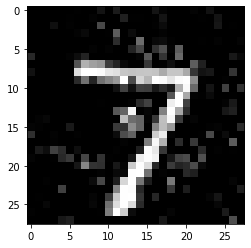

In [16]:
BEST = BEST_X + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [15]:
result=model.predict(best+x_test[0].reshape(1,784))
result[0]

array([2.7823313e-03, 1.2231178e-03, 1.1834574e-01, 3.5964283e-01,
       1.7885446e-04, 7.5152190e-03, 2.4186676e-05, 4.9906772e-01,
       7.4832002e-03, 3.7367700e-03], dtype=float32)

In [12]:
# test
count = 0
for i in range(784):
    if BEST_X[i] != 0:
        count+=1
print(count)

498


In [13]:
# test
count = 0
for i in range(784):
    if BEST_X[i] > 0.8:
        count+=1
print(count)

0


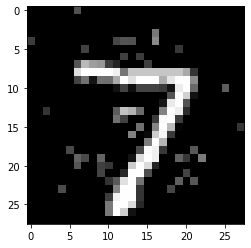

置信度： 0.79100835
[1.5174575e-03 6.5535348e-04 4.4565573e-02 1.5166000e-01 1.2409961e-04
 4.1875131e-03 1.3115628e-05 7.9100835e-01 2.5698482e-03 3.6986568e-03]
扰动程度： 5.808045297534583


In [23]:
#过滤（低强度）
import copy
x_f = copy.deepcopy(BEST_X)
for i in range(784):
    if abs(x_f[i]) < 0.2:
        x_f[i] = 0
f = x_f+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(f.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_f))

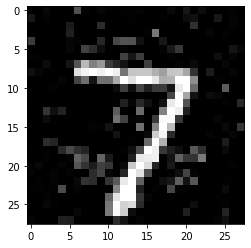

置信度： 0.7140484
[3.5013091e-03 7.0029777e-04 8.5273638e-02 1.8356721e-01 1.1966820e-04
 6.3261571e-03 2.0771509e-05 7.1404839e-01 3.2437495e-03 3.1988441e-03]
扰动程度： 5.399337470712778


In [21]:
#过滤（高强度）
import copy
x_F = copy.deepcopy(BEST_X)
for i in range(784):
    if abs(x_F[i]) > 0.5:
        x_F[i] = 0
F = x_F+x_test[0]
plt.imshow(F.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(F.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_F))

迭代: 1
置信度： 0.79081285


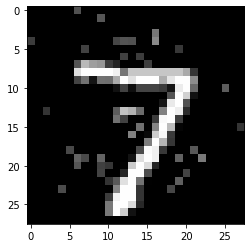

迭代: 2
置信度： 0.78750575


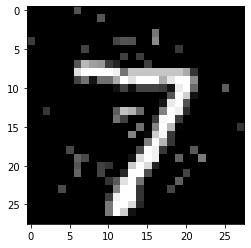

迭代: 3
置信度： 0.7869196


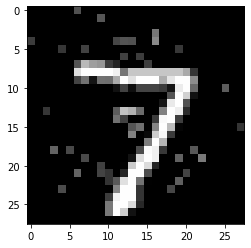

迭代: 4
置信度： 0.7822701


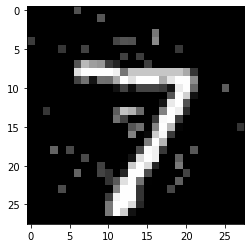

迭代: 5
置信度： 0.78187114


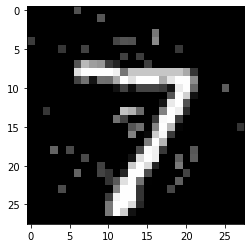

迭代: 6
置信度： 0.777245


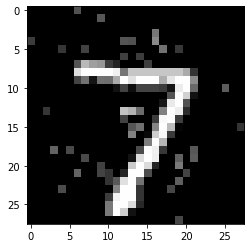

迭代: 7
置信度： 0.7769792


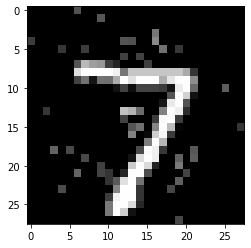

迭代: 8
置信度： 0.77427053


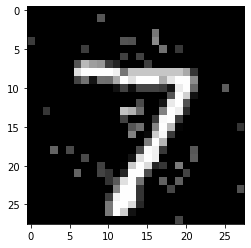

迭代: 9
置信度： 0.7742648


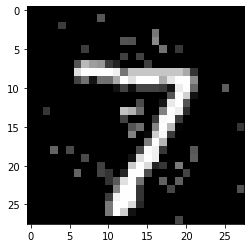

迭代: 10
置信度： 0.77287626


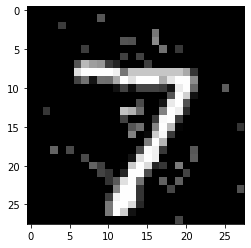

迭代: 11
置信度： 0.7688211


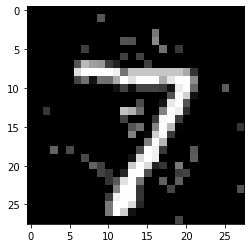

迭代: 12
置信度： 0.76710916


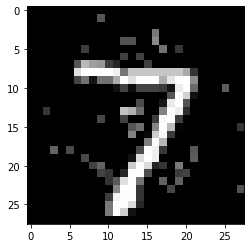

迭代: 13
置信度： 0.76175636


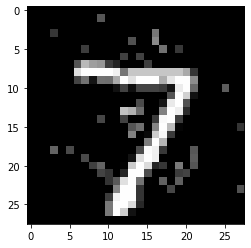

迭代: 14
置信度： 0.754947


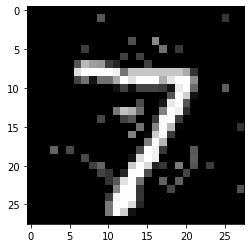

迭代: 15
置信度： 0.73712313


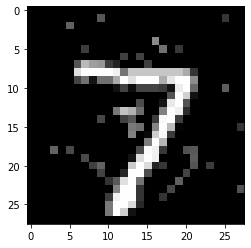

迭代: 16
置信度： 0.73679423


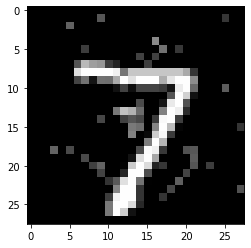

迭代: 17
置信度： 0.7302526


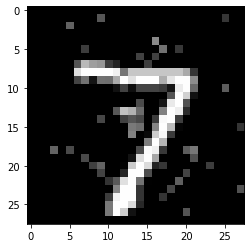

迭代: 18
置信度： 0.7288987


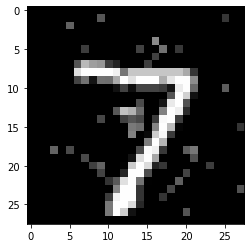

迭代: 19
置信度： 0.72669345


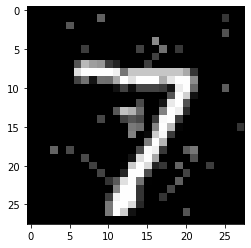

迭代: 20
置信度： 0.7041881


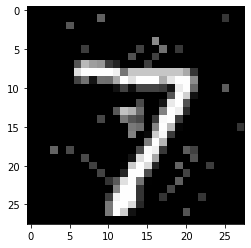

迭代: 21
置信度： 0.69990194


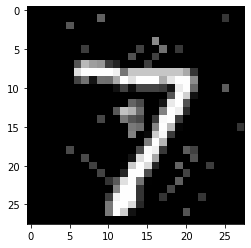

迭代: 22
置信度： 0.69171655


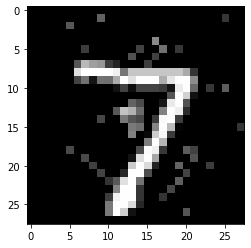

迭代: 23
置信度： 0.69031096


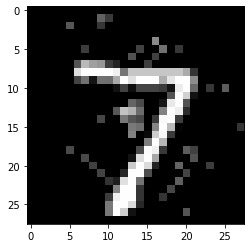

迭代: 24
置信度： 0.6852583


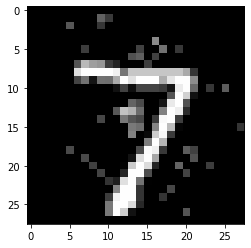

迭代: 25
置信度： 0.6840442


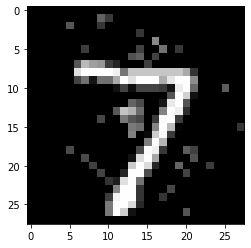

迭代: 26
置信度： 0.672793


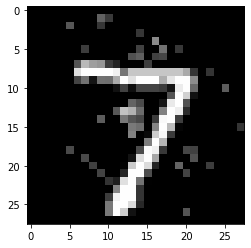

迭代: 27
置信度： 0.6632727


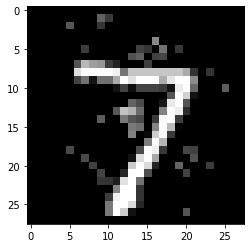

迭代: 28
置信度： 0.6593912


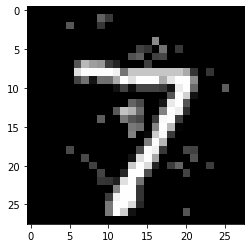

迭代: 29
置信度： 0.65689915


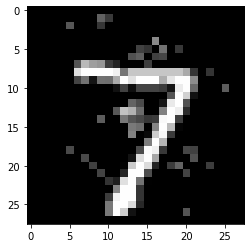

迭代: 30
置信度： 0.642851


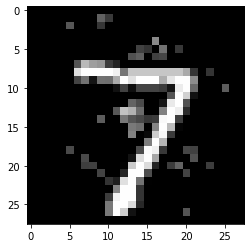

迭代: 31
置信度： 0.6423891


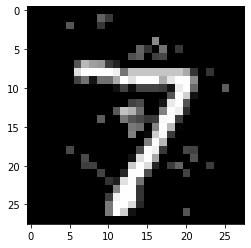

迭代: 32
置信度： 0.6416772


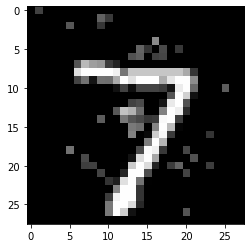

迭代: 33
置信度： 0.6382753


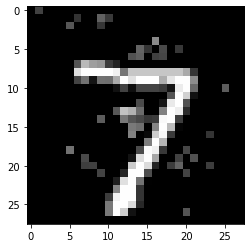

迭代: 34
置信度： 0.6347022


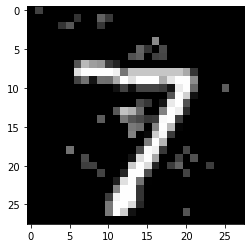

迭代: 35
置信度： 0.6346574


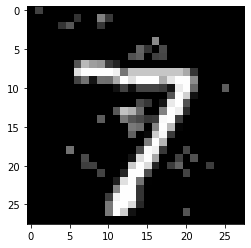

迭代: 36
置信度： 0.6339686


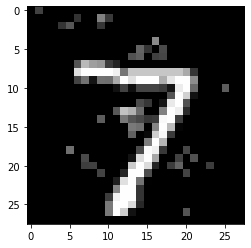

迭代: 37
置信度： 0.63303316


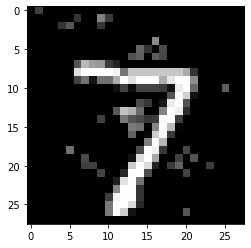

迭代: 38
置信度： 0.6291769


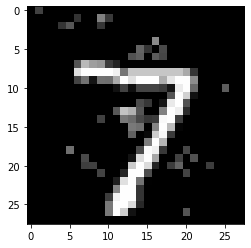

迭代: 39
置信度： 0.6288673


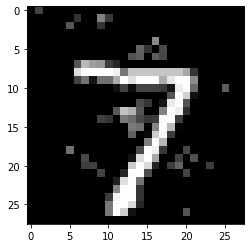

迭代: 40
置信度： 0.6225137


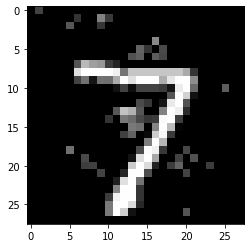

迭代: 41
置信度： 0.6176364


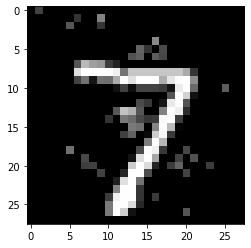

迭代: 42
置信度： 0.61705863


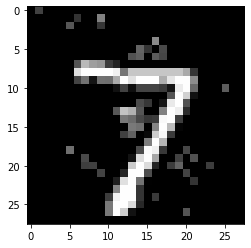

迭代: 43
置信度： 0.611814


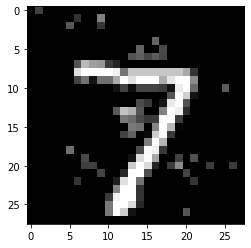

迭代: 44
置信度： 0.6064441


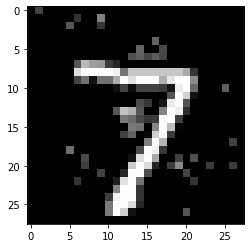

迭代: 45
置信度： 0.5942284


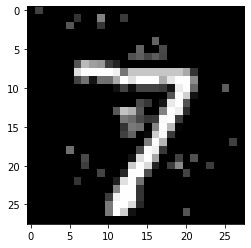

迭代失败


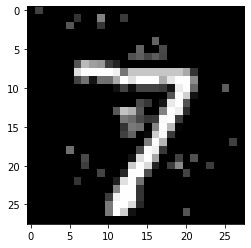

最终置信度： 0.5942284
最终扰动程度： 5.808045297534582
[1.0967220e-03 9.6672133e-04 4.5148227e-02 3.4004280e-01 1.6902824e-04
 4.2748246e-03 1.2764148e-05 5.9422839e-01 6.3656499e-03 7.6948670e-03]


In [24]:
# 改变坐标减小置信度（过滤0.2）
import copy
x_t = copy.deepcopy(x_f)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


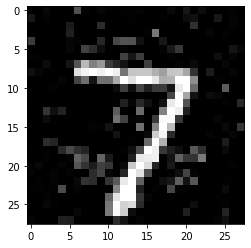

最终置信度： 0.7140484
最终扰动程度： 5.399337470712778
[3.5013091e-03 7.0029777e-04 8.5273638e-02 1.8356721e-01 1.1966820e-04
 6.3261571e-03 2.0771509e-05 7.1404839e-01 3.2437495e-03 3.1988441e-03]


In [22]:
# 改变坐标减小置信度（过滤0.5）
import copy
x_t = copy.deepcopy(x_F)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


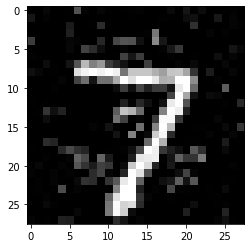

最终置信度： 0.39767227
最终扰动程度： 7.0038201815486
[3.7777259e-03 1.0443135e-03 1.1682559e-01 4.5660120e-01 1.5665211e-04
 1.2439688e-02 3.2627453e-05 3.9767227e-01 7.4698036e-03 3.9801179e-03]


In [11]:
# 改变坐标减小置信度
import copy
x_t = copy.deepcopy(BEST_X)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])